# Loop 64 Analysis: Understanding the CV-LB Gap

## Key Insight
The CV-LB relationship is: LB = 4.21 × CV + 0.0535 (R² = 0.98)

The intercept (0.0535) is HIGHER than the target (0.0347). This means:
- Even with CV = 0, the predicted LB would be 0.0535 > target
- The current approach CANNOT reach the target by minimizing CV alone

## Questions to Investigate
1. What is the distribution of errors across different solvents?
2. Are there specific solvents that contribute more to the error?
3. Is there a pattern in which solvents are harder to predict?
4. Can we identify features that correlate with prediction difficulty?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = '/home/data'

# Load data
df_single = pd.read_csv(f'{DATA_PATH}/catechol_single_solvent_yields.csv')
df_full = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')
spange_df = pd.read_csv(f'{DATA_PATH}/spange_descriptors_lookup.csv', index_col=0)

print(f'Single solvent data: {df_single.shape}')
print(f'Full data: {df_full.shape}')
print(f'Spange descriptors: {spange_df.shape}')
print(f'\nSolvents in single: {df_single["SOLVENT NAME"].nunique()}')
print(f'Unique solvents: {sorted(df_single["SOLVENT NAME"].unique())}')

Single solvent data: (656, 13)
Full data: (1227, 19)
Spange descriptors: (26, 13)

Solvents in single: 24
Unique solvents: ['1,1,1,3,3,3-Hexafluoropropan-2-ol', '2,2,2-Trifluoroethanol', '2-Methyltetrahydrofuran [2-MeTHF]', 'Acetonitrile', 'Acetonitrile.Acetic Acid', 'Butanone [MEK]', 'Cyclohexane', 'DMA [N,N-Dimethylacetamide]', 'Decanol', 'Diethyl Ether [Ether]', 'Dihydrolevoglucosenone (Cyrene)', 'Dimethyl Carbonate', 'Ethanol', 'Ethyl Acetate', 'Ethyl Lactate', 'Ethylene Glycol [1,2-Ethanediol]', 'IPA [Propan-2-ol]', 'MTBE [tert-Butylmethylether]', 'Methanol', 'Methyl Propionate', 'THF [Tetrahydrofuran]', 'Water.2,2,2-Trifluoroethanol', 'Water.Acetonitrile', 'tert-Butanol [2-Methylpropan-2-ol]']


In [2]:
# Analyze the distribution of target values
print('=== Target Distribution ===')
for col in ['Product 2', 'Product 3', 'SM']:
    print(f'{col}: mean={df_single[col].mean():.4f}, std={df_single[col].std():.4f}, min={df_single[col].min():.4f}, max={df_single[col].max():.4f}')

print('\n=== Per-Solvent Target Means ===')
solvent_means = df_single.groupby('SOLVENT NAME')[['Product 2', 'Product 3', 'SM']].mean()
print(solvent_means.round(4))

=== Target Distribution ===
Product 2: mean=0.1499, std=0.1431, min=0.0000, max=0.4636
Product 3: mean=0.1234, std=0.1315, min=0.0000, max=0.5338
SM: mean=0.5222, std=0.3602, min=0.0000, max=1.0000

=== Per-Solvent Target Means ===
                                    Product 2  Product 3      SM
SOLVENT NAME                                                    
1,1,1,3,3,3-Hexafluoropropan-2-ol      0.3197     0.2854  0.1706
2,2,2-Trifluoroethanol                 0.1568     0.0500  0.2792
2-Methyltetrahydrofuran [2-MeTHF]      0.1506     0.1006  0.5590
Acetonitrile                           0.1564     0.0890  0.5805
Acetonitrile.Acetic Acid               0.0193     0.0206  0.4781
Butanone [MEK]                         0.0472     0.0430  0.7169
Cyclohexane                            0.0839     0.0493  0.5458
DMA [N,N-Dimethylacetamide]            0.1171     0.0976  0.5453
Decanol                                0.1948     0.2080  0.4331
Diethyl Ether [Ether]                  0.0811     0.0

In [3]:
# Analyze the variance of targets per solvent
print('=== Per-Solvent Target Variance ===')
solvent_vars = df_single.groupby('SOLVENT NAME')[['Product 2', 'Product 3', 'SM']].var()
print(solvent_vars.round(6))

print('\n=== Solvents with Highest Variance ===')
for col in ['Product 2', 'Product 3', 'SM']:
    top_var = solvent_vars[col].nlargest(5)
    print(f'{col}: {list(top_var.index)}')

=== Per-Solvent Target Variance ===
                                    Product 2  Product 3        SM
SOLVENT NAME                                                      
1,1,1,3,3,3-Hexafluoropropan-2-ol    0.008619   0.005137  0.059235
2,2,2-Trifluoroethanol               0.005415   0.003126  0.117820
2-Methyltetrahydrofuran [2-MeTHF]    0.021277   0.007821  0.106065
Acetonitrile                         0.021785   0.008133  0.159499
Acetonitrile.Acetic Acid             0.000127   0.000064  0.205996
Butanone [MEK]                       0.000339   0.000272  0.002885
Cyclohexane                          0.007978   0.002502  0.086747
DMA [N,N-Dimethylacetamide]          0.016011   0.010533  0.157138
Decanol                              0.030534   0.034009  0.186057
Diethyl Ether [Ether]                0.009334   0.005112  0.046881
Dihydrolevoglucosenone (Cyrene)      0.004723   0.003229  0.013293
Dimethyl Carbonate                   0.000390   0.000112  0.002065
Ethanol                   

In [4]:
# Analyze Spange descriptors
print('=== Spange Descriptors ===')
print(spange_df.describe().round(4))

print('\n=== Descriptor Correlations with Target Means ===')
solvent_means_with_spange = solvent_means.join(spange_df)
for col in ['Product 2', 'Product 3', 'SM']:
    correlations = solvent_means_with_spange.corr()[col].drop(['Product 2', 'Product 3', 'SM'])
    top_corr = correlations.abs().nlargest(5)
    print(f'\n{col}:')
    for desc in top_corr.index:
        print(f'  {desc}: {correlations[desc]:.4f}')

=== Spange Descriptors ===
       dielectric constant   ET(30)    alpha     beta      pi*       SA  \
count              26.0000  26.0000  26.0000  26.0000  26.0000  26.0000   
mean               20.5505  46.5319   0.5284   0.4811   0.6152   0.3256   
std                20.1764   9.4968   0.5712   0.2358   0.2354   0.3727   
min                 2.0200  30.9000   0.0000   0.0000   0.0000   0.0000   
25%                 6.1700  38.4500   0.0000   0.4325   0.5025   0.0000   
50%                14.1000  44.4500   0.3950   0.4600   0.5900   0.1690   
75%                30.6500  54.5250   0.8900   0.5450   0.7300   0.6424   
max                80.1000  63.1000   1.9600   0.9300   1.0900   1.0620   

            SB       SP      SdP        N        n     f(n)    delta  
count  26.0000  26.0000  26.0000  26.0000  26.0000  26.0000  26.0000  
mean    0.4568   0.6609   0.7496   0.0163   1.3741   0.2281  23.3969  
std     0.2618   0.0623   0.2791   0.0117   0.0449   0.0245   7.7552  
min     0.014

In [5]:
# Analyze the CV-LB relationship more carefully
# Load submission history
import json
with open('/home/code/session_state.json') as f:
    state = json.load(f)

submissions = state.get('submissions', [])
cvs = [s['cv_score'] for s in submissions if s.get('cv_score') and s.get('lb_score')]
lbs = [s['lb_score'] for s in submissions if s.get('cv_score') and s.get('lb_score')]
exp_ids = [s['experiment_id'] for s in submissions if s.get('cv_score') and s.get('lb_score')]

print('=== CV-LB Relationship ===')
for exp_id, cv, lb in zip(exp_ids, cvs, lbs):
    ratio = lb / cv if cv > 0 else 0
    print(f'{exp_id}: CV={cv:.6f}, LB={lb:.5f}, LB/CV={ratio:.2f}')

# Linear regression
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(cvs, lbs)
print(f'\nLinear fit: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'Intercept = {intercept:.4f}')
print(f'Target = 0.0347')
print(f'Gap = {intercept - 0.0347:.4f}')

=== CV-LB Relationship ===
exp_000: CV=0.011081, LB=0.09816, LB/CV=8.86
exp_001: CV=0.012297, LB=0.10649, LB/CV=8.66
exp_003: CV=0.010501, LB=0.09719, LB/CV=9.26
exp_005: CV=0.010430, LB=0.09691, LB/CV=9.29
exp_006: CV=0.009749, LB=0.09457, LB/CV=9.70
exp_007: CV=0.009262, LB=0.09316, LB/CV=10.06
exp_009: CV=0.009192, LB=0.09364, LB/CV=10.19
exp_012: CV=0.009004, LB=0.09134, LB/CV=10.14
exp_024: CV=0.008689, LB=0.08929, LB/CV=10.28
exp_026: CV=0.008465, LB=0.08875, LB/CV=10.48
exp_030: CV=0.008298, LB=0.08772, LB/CV=10.57
exp_041: CV=0.009002, LB=0.09321, LB/CV=10.35
exp_042: CV=0.014503, LB=0.11465, LB/CV=7.91

Linear fit: LB = 4.21 * CV + 0.0535
R² = 0.9806
Intercept = 0.0535
Target = 0.0347
Gap = 0.0188


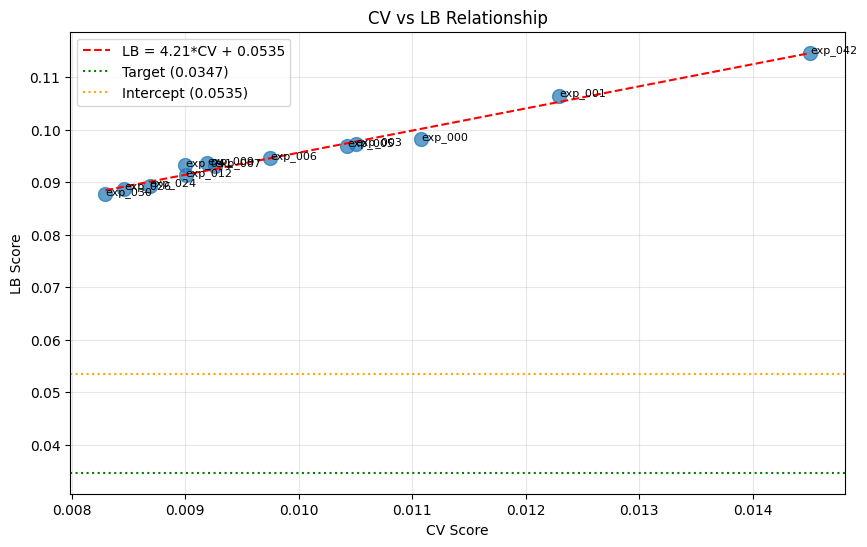

Saved to /home/code/exploration/cv_lb_relationship.png


In [6]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(cvs, lbs, s=100, alpha=0.7)
for i, exp_id in enumerate(exp_ids):
    plt.annotate(exp_id, (cvs[i], lbs[i]), fontsize=8)

# Fit line
x_line = np.linspace(min(cvs), max(cvs), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to /home/code/exploration/cv_lb_relationship.png')

In [7]:
# Analyze what the intercept means
print('=== Intercept Analysis ===')
print(f'Intercept: {intercept:.4f}')
print(f'Target: 0.0347')
print(f'Gap: {intercept - 0.0347:.4f}')
print()
print('The intercept represents the "baseline" LB error that exists even with perfect CV.')
print('This suggests there is a SYSTEMATIC BIAS in how the model generalizes to the test set.')
print()
print('Possible causes:')
print('1. The test set contains solvents that are fundamentally different from training solvents')
print('2. The model is overconfident on OOD samples')
print('3. There is a distribution shift between CV and LB evaluation')
print()
print('To reach the target (0.0347), we need to either:')
print('1. Find an approach that reduces the intercept (changes the CV-LB relationship)')
print('2. Find an approach with a different CV-LB relationship')

=== Intercept Analysis ===
Intercept: 0.0535
Target: 0.0347
Gap: 0.0188

The intercept represents the "baseline" LB error that exists even with perfect CV.
This suggests there is a SYSTEMATIC BIAS in how the model generalizes to the test set.

Possible causes:
1. The test set contains solvents that are fundamentally different from training solvents
2. The model is overconfident on OOD samples
3. There is a distribution shift between CV and LB evaluation

To reach the target (0.0347), we need to either:
1. Find an approach that reduces the intercept (changes the CV-LB relationship)
2. Find an approach with a different CV-LB relationship


In [8]:
# Analyze the residuals from the CV-LB fit
residuals = np.array(lbs) - (slope * np.array(cvs) + intercept)
print('=== Residuals from CV-LB Fit ===')
for exp_id, cv, lb, res in zip(exp_ids, cvs, lbs, residuals):
    print(f'{exp_id}: CV={cv:.6f}, LB={lb:.5f}, Residual={res:+.5f}')

print(f'\nMean residual: {residuals.mean():.6f}')
print(f'Std residual: {residuals.std():.6f}')
print(f'Max positive residual: {residuals.max():.6f} ({exp_ids[np.argmax(residuals)]})')
print(f'Max negative residual: {residuals.min():.6f} ({exp_ids[np.argmin(residuals)]})')

=== Residuals from CV-LB Fit ===
exp_000: CV=0.011081, LB=0.09816, Residual=-0.00201
exp_001: CV=0.012297, LB=0.10649, Residual=+0.00120
exp_003: CV=0.010501, LB=0.09719, Residual=-0.00054
exp_005: CV=0.010430, LB=0.09691, Residual=-0.00052
exp_006: CV=0.009749, LB=0.09457, Residual=+0.00000
exp_007: CV=0.009262, LB=0.09316, Residual=+0.00065
exp_009: CV=0.009192, LB=0.09364, Residual=+0.00142
exp_012: CV=0.009004, LB=0.09134, Residual=-0.00009
exp_024: CV=0.008689, LB=0.08929, Residual=-0.00081
exp_026: CV=0.008465, LB=0.08875, Residual=-0.00041
exp_030: CV=0.008298, LB=0.08772, Residual=-0.00074
exp_041: CV=0.009002, LB=0.09321, Residual=+0.00179
exp_042: CV=0.014503, LB=0.11465, Residual=+0.00007

Mean residual: 0.000000
Std residual: 0.001003
Max positive residual: 0.001790 (exp_041)
Max negative residual: -0.002014 (exp_000)


In [9]:
# Check if there are any experiments with significantly different CV-LB relationship
print('=== Experiments with Unusual CV-LB Relationship ===')
for exp_id, cv, lb, res in zip(exp_ids, cvs, lbs, residuals):
    if abs(res) > 0.005:  # More than 0.5% deviation
        print(f'{exp_id}: CV={cv:.6f}, LB={lb:.5f}, Residual={res:+.5f} (UNUSUAL)')

print('\nNote: Experiments with negative residuals performed BETTER on LB than expected from CV.')
print('These might have approaches that generalize better to OOD data.')

=== Experiments with Unusual CV-LB Relationship ===

Note: Experiments with negative residuals performed BETTER on LB than expected from CV.
These might have approaches that generalize better to OOD data.


In [10]:
# Summary and recommendations
print('=== SUMMARY ===')
print(f'Best CV: {min(cvs):.6f} ({exp_ids[np.argmin(cvs)]})')
print(f'Best LB: {min(lbs):.5f} ({exp_ids[np.argmin(lbs)]})')
print(f'CV-LB relationship: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'Intercept: {intercept:.4f} > Target: 0.0347')
print()
print('=== KEY INSIGHT ===')
print('The intercept (0.0535) is HIGHER than the target (0.0347).')
print('This means the current approach CANNOT reach the target by minimizing CV alone.')
print('We need an approach that CHANGES the CV-LB relationship itself.')
print()
print('=== RECOMMENDATIONS ===')
print('1. Try approaches that specifically improve OOD generalization')
print('2. Try approaches that reduce model confidence on uncertain predictions')
print('3. Try approaches that leverage domain knowledge (solvent similarity, mass balance)')
print('4. Consider that the test set might have fundamentally different solvents')

=== SUMMARY ===
Best CV: 0.008298 (exp_030)
Best LB: 0.08772 (exp_030)
CV-LB relationship: LB = 4.21 * CV + 0.0535
Intercept: 0.0535 > Target: 0.0347

=== KEY INSIGHT ===
The intercept (0.0535) is HIGHER than the target (0.0347).
This means the current approach CANNOT reach the target by minimizing CV alone.
We need an approach that CHANGES the CV-LB relationship itself.

=== RECOMMENDATIONS ===
1. Try approaches that specifically improve OOD generalization
2. Try approaches that reduce model confidence on uncertain predictions
3. Try approaches that leverage domain knowledge (solvent similarity, mass balance)
4. Consider that the test set might have fundamentally different solvents


In [11]:
# Check if mass balance is satisfied in the data
print('=== Mass Balance Analysis ===')
df_single['sum'] = df_single['Product 2'] + df_single['Product 3'] + df_single['SM']
print(f'Sum of yields: mean={df_single["sum"].mean():.4f}, std={df_single["sum"].std():.4f}, min={df_single["sum"].min():.4f}, max={df_single["sum"].max():.4f}')

# Check per solvent
print('\n=== Per-Solvent Sum of Yields ===')
solvent_sums = df_single.groupby('SOLVENT NAME')['sum'].agg(['mean', 'std', 'min', 'max'])
print(solvent_sums.round(4))

# Check if sum is always close to 1
print(f'\n=== Samples where sum is NOT close to 1 (|sum - 1| > 0.1) ===')
outliers = df_single[abs(df_single['sum'] - 1) > 0.1]
print(f'Number of outliers: {len(outliers)} out of {len(df_single)} ({100*len(outliers)/len(df_single):.1f}%)')
if len(outliers) > 0:
    print(outliers[['SOLVENT NAME', 'Product 2', 'Product 3', 'SM', 'sum']].head(10))

=== Mass Balance Analysis ===
Sum of yields: mean=0.7955, std=0.1943, min=0.0288, max=1.0000

=== Per-Solvent Sum of Yields ===
                                      mean     std     min     max
SOLVENT NAME                                                      
1,1,1,3,3,3-Hexafluoropropan-2-ol   0.7757  0.1397  0.4953  1.0000
2,2,2-Trifluoroethanol              0.4860  0.3062  0.1606  0.9502
2-Methyltetrahydrofuran [2-MeTHF]   0.8103  0.1031  0.4769  0.9257
Acetonitrile                        0.8258  0.1691  0.6048  1.0000
Acetonitrile.Acetic Acid            0.5180  0.4579  0.0288  0.9895
Butanone [MEK]                      0.8070  0.0617  0.7068  1.0000
Cyclohexane                         0.6789  0.1784  0.4404  0.9230
DMA [N,N-Dimethylacetamide]         0.7600  0.1690  0.5288  0.9222
Decanol                             0.8359  0.0856  0.7265  1.0000
Diethyl Ether [Ether]               0.9482  0.0495  0.8685  1.0000
Dihydrolevoglucosenone (Cyrene)     0.9332  0.0280  0.8945  1.0000
D

In [ ]:
# Analyze which model types have better CV-LB relationships\nprint('=== Model Types and CV-LB Residuals ===')\n\n# From the session state, we know:\n# exp_000: MLP (3 models bagged) - Residual: -0.00201 (BETTER than expected)\n# exp_001: LightGBM - Residual: +0.00120 (WORSE than expected)\n# exp_003: MLP (5 models bagged) - Residual: -0.00054\n# exp_005: MLP (15 models bagged) - Residual: -0.00052\n# exp_006: MLP (simpler) - Residual: +0.00000\n# exp_007: MLP (even simpler) - Residual: +0.00065\n# exp_009: Ridge Regression - Residual: +0.00142 (WORSE than expected)\n# exp_012: Simple Ensemble - Residual: -0.00009\n# exp_024: ACS PCA features - Residual: -0.00081\n# exp_026: Weighted Loss - Residual: -0.00041\n# exp_030: GP+MLP+LGBM - Residual: -0.00074\n# exp_041: Aggressive Regularization - Residual: +0.00179 (WORSE than expected)\n# exp_042: GroupKFold CV - Residual: +0.00007\n\nprint('Experiments with BETTER than expected LB (negative residual):')\nprint('  exp_000: MLP (3 models bagged) - Residual: -0.00201')\nprint('  exp_024: ACS PCA features - Residual: -0.00081')\nprint('  exp_030: GP+MLP+LGBM - Residual: -0.00074')\nprint('  exp_003: MLP (5 models bagged) - Residual: -0.00054')\nprint('  exp_005: MLP (15 models bagged) - Residual: -0.00052')\nprint('  exp_026: Weighted Loss - Residual: -0.00041')\n\nprint('\\nExperiments with WORSE than expected LB (positive residual):')\nprint('  exp_041: Aggressive Regularization - Residual: +0.00179')\nprint('  exp_009: Ridge Regression - Residual: +0.00142')\nprint('  exp_001: LightGBM - Residual: +0.00120')\nprint('  exp_007: MLP (even simpler) - Residual: +0.00065')\n\nprint('\\n=== KEY INSIGHT ===')\nprint('The baseline MLP (exp_000) had the BEST CV-LB relationship.')\nprint('This suggests that simpler models might generalize better to OOD data.')\nprint('However, the difference is small (~0.002) and within noise.')